This requires you to write a 2D GAN game. I let you to get into the topic yourself, whitout any explonations from my side. You can watch lecture, seminar, read papers and tutorials (fun, fun, fun).

### Homework

I want you to implement a simple 2D GAN game. The kind of animation, I want to see is like in [this video](https://www.youtube.com/watch?v=KeJINHjyzOU) at 15:30 or in [here](https://habrahabr.ru/post/275429/) but in 2D. You can google, search code at github, whatever, but the network should be based on Theano. 

Basically you will need to come up with true distribution $P$, say mixture of gaussians (surprise me), sample some data from it. Visualize it as a heatmap. To visualize $G$ density you can fix $N$ noise vectors $\{z_i\} \quad i=1,\dots, N$ and draw a circle for each $G(z_i)$. It is also funny to visualize discriminator as a vector field (can be done with `plt.arrow`, `plt.quiver plo). Look how it should be in the middle of [this page](http://www.inference.vc/an-alternative-update-rule-for-generative-adversarial-networks/).

Please, make sure your code works if 'Run All' is pressed and it draws some animation.

Good luck!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import lasagne
import theano
import theano.tensor as T
from lasagne.nonlinearities import rectify, sigmoid, linear, tanh, leaky_rectify, sigmoid, elu
from scipy.stats import norm
import seaborn as sns

Using gpu device 0: Quadro M1000M (CNMeM is disabled, cuDNN 5105)
/home/ivan/.virtualenvs/math/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
# generator
G_input = T.matrix('Gx')
G_l1 = lasagne.layers.InputLayer((None, 2), G_input)
G_l2 = lasagne.layers.DenseLayer(G_l1, 30, nonlinearity=rectify)
G_l3 = lasagne.layers.DenseLayer(G_l2, 25, nonlinearity=rectify)
G_l4 = lasagne.layers.DenseLayer(G_l3, 15, nonlinearity=rectify)
G_l5 = lasagne.layers.DenseLayer(G_l4, 10, nonlinearity=rectify)
G_l6 = lasagne.layers.DenseLayer(G_l5, 2, nonlinearity=elu)
G = G_l6

G_out = lasagne.layers.get_output(G)

In [3]:
# discriminators
D1_input = T.matrix('D1x')
D1_target = T.matrix('D1y')
D1_l1 = lasagne.layers.InputLayer((None, 2), D1_input)
D1_l2 = lasagne.layers.DenseLayer(D1_l1, 10, nonlinearity=tanh)
D1_l3 = lasagne.layers.DenseLayer(D1_l2, 10, nonlinearity=tanh)
D1_l4 = lasagne.layers.DenseLayer(D1_l3, 1, nonlinearity=sigmoid)
D1 = D1_l4

D2_l1 = lasagne.layers.InputLayer((None, 2), G_out)
D2_l2 = lasagne.layers.DenseLayer(D2_l1, 10, nonlinearity=tanh, W=D1_l2.W, b=D1_l2.b)
D2_l3 = lasagne.layers.DenseLayer(D2_l2, 10, nonlinearity=tanh, W=D1_l3.W, b=D1_l3.b)
D2_l4 = lasagne.layers.DenseLayer(D2_l3, 1, nonlinearity=sigmoid, W=D1_l4.W, b=D1_l4.b)
D2 = D2_l4

D1_out = lasagne.layers.get_output(D1)
D2_out = lasagne.layers.get_output(D2)

In [4]:
# output functions
discriminate = theano.function([D1_input], D1_out)
generate = theano.function([G_input], G_out)

G_obj = (T.log(D2_out)).mean()
D_obj = (T.log(D1_out) + T.log(1 - D2_out)).mean()

# parameters update and training
G_params = lasagne.layers.get_all_params(G, trainable=True)
G_lr = theano.shared(np.array(0.01, dtype=theano.config.floatX))
G_updates = lasagne.updates.nesterov_momentum(1 - G_obj, G_params, learning_rate=G_lr, momentum=0.6)
G_train = theano.function([G_input], G_obj, updates=G_updates)

D_params = lasagne.layers.get_all_params(D1, trainable=True)
D_lr = theano.shared(np.array(0.1, dtype=theano.config.floatX))
D_updates = lasagne.updates.nesterov_momentum(1 - D_obj, D_params, learning_rate=D_lr, momentum=0.6)
D_train = theano.function([G_input, D1_input], D_obj, updates=D_updates)

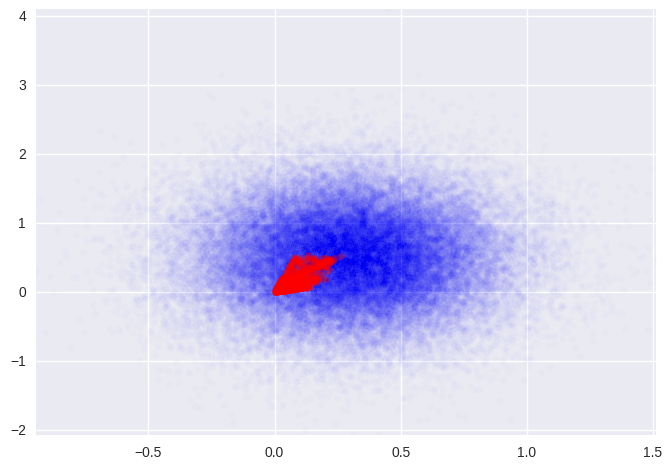

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

mean = [0.3, 0.5]
cov = [[0.1, 0.], [0., 0.4]]
k = 100
M = 600

dataset = [np.float32(np.random.multivariate_normal(mean, cov, M)) for _ in range(k)]
x, y = np.concatenate(dataset).T
x_min, x_max = np.min(x), np.max(x)
y_min, y_max = np.min(y), np.max(y)


def sample_noise(sz):
    return np.array([np.linspace(x_min, x_max, sz) + np.random.random(sz) * 0.05,
                     np.linspace(y_min, y_max, sz) + np.random.random(sz) * 0.05], 
                    dtype=np.float32)[:,np.random.permutation(sz)].reshape(sz, 2)


def ls(sz):
    return np.array([np.linspace(x_min, x_max, sz), np.linspace(y_min, y_max, sz)], 
                    dtype=np.float32)[:,np.random.permutation(sz)].reshape(sz, 2)




def plot_state(gen, discr, batch_size=1000, fname=None):
    plt.xlim((x_min, x_max))
    plt.ylim((y_min, y_max))
    xs = ls(batch_size)
    
    ds = discriminate(xs.reshape(batch_size, 2))
    gs = generate(sample_noise(batch_size))
    
    
    plt.scatter(np.concatenate(dataset).T[0], np.concatenate(dataset).T[1], color="b", alpha=0.01)
    plt.scatter(gs.T[0], gs.T[1], color="r", alpha=0.3)

    
    if fname:
        plt.savefig(fname)
        plt.cla()
    else:
        plt.show()
        
plot_state(generate, discriminate)

In [6]:
!rm -rf ani_2d/
!mkdir -p ani_2d/

50


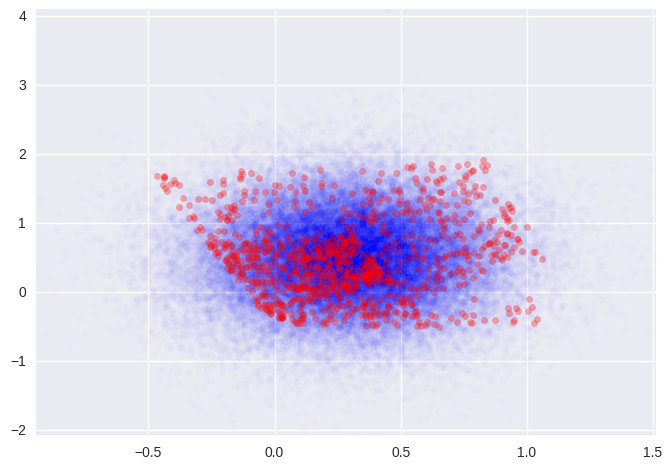

100


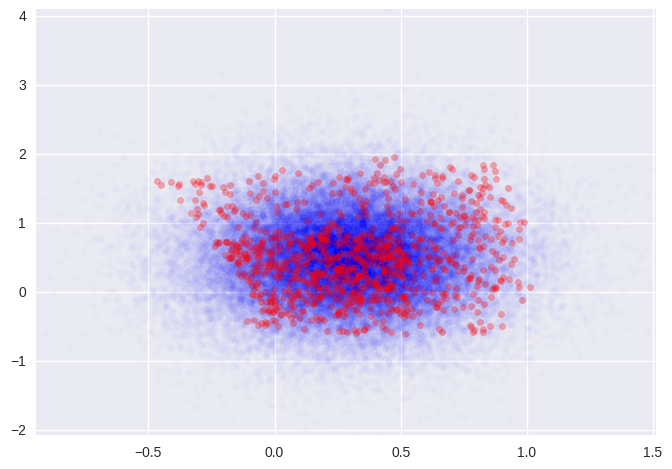

150


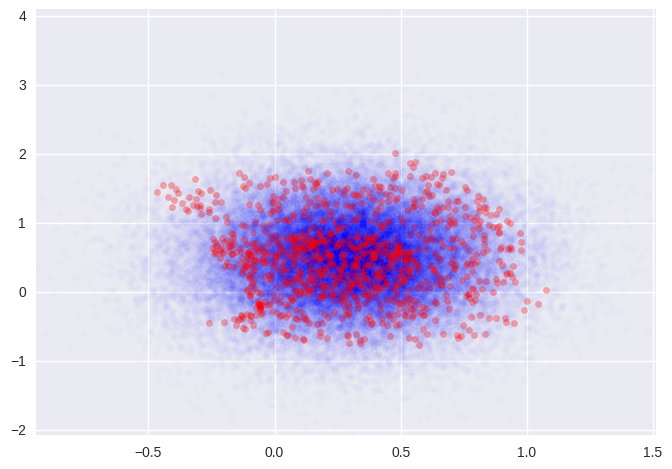

In [7]:
epochs = 150
histd, histg = np.zeros(epochs), np.zeros(epochs)

plt.ion()

for i in range(epochs):
    plot_state(generate, discriminate, fname="ani_2d/{:04d}.jpg".format(i))
    
    for x in dataset:
        n_size = x.shape[0]
        z = sample_noise(n_size)
        histd[i] = D_train(z, x)
        
    
    z = sample_noise(n_size)
    histg[i] = G_train(z)
    
    
    if (i + 1) % 50 == 0:
        G_lr *= 0.999
        D_lr *= 0.999
        print(i + 1)
        
        plot_state(generate, discriminate, fname=None)

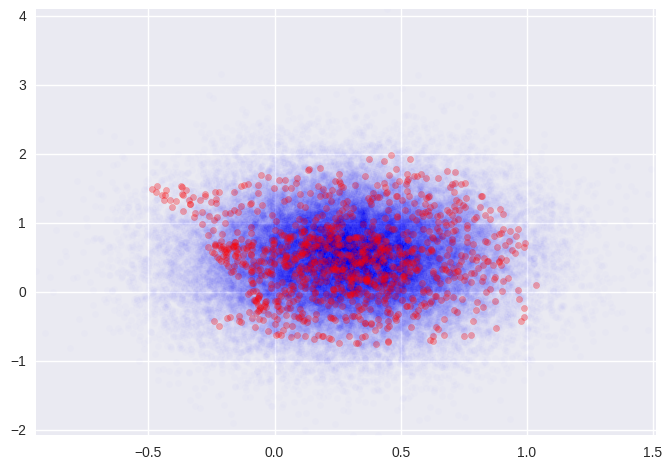

In [8]:
plot_state(generate, discriminate)

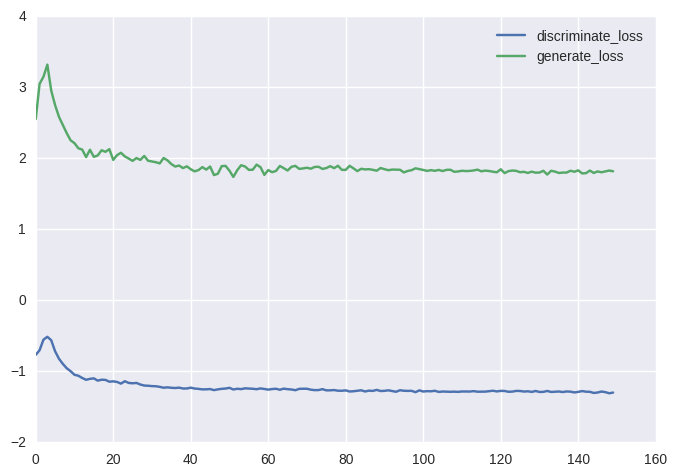

In [9]:
plt.plot(range(epochs), histd, label='discriminate_loss')
plt.plot(range(epochs), 1 - histg, label='generate_loss')
plt.legend()
plt.show()

In [10]:
%%time

!convert -delay 5 10 -loop 0 ani_2d/*.jpg "2d_animation.gif"

convert-im6.q16: unable to open image `10': No such file or directory @ error/blob.c/OpenBlob/2701.
convert-im6.q16: no decode delegate for this image format `' @ error/constitute.c/ReadImage/504.
CPU times: user 396 ms, sys: 96 ms, total: 492 ms
Wall time: 25.1 s


In [11]:
from IPython.display import Image
Image(url='2d_animation.gif')